In [1]:
import numpy as np
import scipy
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

from tools import depletion_func, calc_total_reward_rate, moving_window_avg

In [3]:
# Example usage
type_patches = 2
travel_time = 7
site_stops = [1,9]
reward_value = [5,5]
num_patches = 400

#Three alternative ways to generate a list of patches
patch_list = range(type_patches) #equal distribution of patches
patch_list = [random.randint(0, 1) for _ in range(num_patches)] #randomly generated list of patched
# patch_list = data # import data from session {To Be Implemented..}

# Initial probabilities of reward in each patch
a = [.9, .4]
b = [2.76, 2.76]
c = [.1278, .1278]
d = [0, 0]

total_reward_rate = calc_total_reward_rate(patch_list, travel_time, site_stops, reward_value, a, b, c, d)
print(f"Total reward rate: {total_reward_rate}")

Total reward rate: 0.6543421981200982


In [4]:
# Initial probabilities of reward in each patch
grid = np.zeros((20,20))
for x in range(20):
    for y in range (20):
        total_reward_rate = calc_total_reward_rate(range(type_patches), travel_time, [x,y,0], reward_value, a, b, c, d)
        grid[x,y] = total_reward_rate
        
# Find the indices of the maximum value(s) in the grid
best_time = np.unravel_index(grid.argmax(), grid.shape)

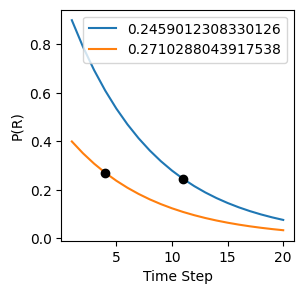

In [5]:
import matplotlib.pyplot as plt

max_time = 20

# Create a range of time steps
time_steps = np.arange(max_time)

# Plot the depletion rate over time
plt.figure(figsize=(3, 3))

for patch_id in range(type_patches): #could change this to a list of patches in order
    
    # Compute the depletion rate for each time step
    p_R = [depletion_func(a[patch_id],b[patch_id],c[patch_id],d[patch_id],t) for t in time_steps]

    plt.plot(time_steps+1, p_R,label = str(p_R[best_time[patch_id]-1]))
    plt.plot(best_time[patch_id], p_R[best_time[patch_id]-1],'ok')

plt.xlabel('Time Step')
plt.ylabel('P(R)')
plt.legend()
plt.show()

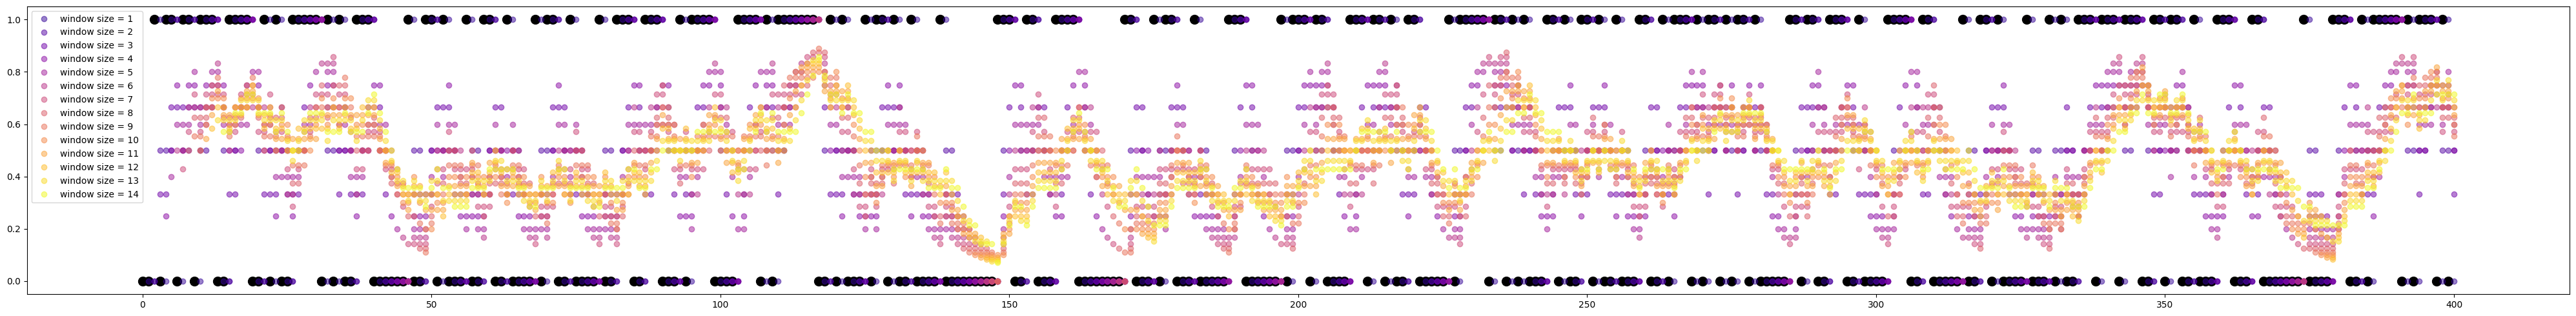

In [6]:
window_size_max = 15

fig = plt.figure(figsize=(40,5),tight_layout=True,facecolor='white')
plt.plot(patch_list,'ok',markersize = 10)
cmap = mpl.colormaps['plasma'].resampled(window_size_max)


for window_size in range(1,window_size_max):

    # Calculate moving window averages with different window sizes
    window_ave = moving_window_avg(patch_list, window_size)

    plt.plot(window_ave,'o',alpha = .5, color = cmap(window_size/window_size_max), label = 'window size = '+str(window_size))

plt.legend()
plt.show()

In [7]:
##Gonna write a grid search for combinations of patch distributions, but have to rewrite if there are more than two patches.

In [8]:
# Initial probabilities of reward in each patch
max_stops = 20
grid = np.zeros((window_size_max+1,max_stops,max_stops))

for patch_ratio in range(window_size_max+1):
    
    patch_list = np.concatenate((np.ones(patch_ratio), np.zeros(window_size_max - patch_ratio))).astype(int).tolist()
    
    for x in range(max_stops):
        for y in range (max_stops):
            total_reward_rate = calc_total_reward_rate(patch_list, travel_time, [x,y,0], reward_value, a, b, c, d)
            grid[patch_ratio,x,y] = total_reward_rate

In [9]:
# Initialize lists to store the results
max_total_reward_rates = []
best_x_indices = []
best_y_indices = []

# Loop over all patch_ratio values
for patch_ratio in range(window_size_max+1):
    # Find the maximum value and its indices for the current patch_ratio
    max_value = np.max(grid[patch_ratio])
    max_index = np.unravel_index(np.argmax(grid[patch_ratio]), (max_stops, max_stops))
    
    # Store the results
    max_total_reward_rates.append(max_value)
    best_x_indices.append(max_index[0])
    best_y_indices.append(max_index[1])

print("Maximum total reward rates:", max_total_reward_rates)
print("Best x indices:", best_x_indices)
print("Best y indices:", best_y_indices)

Maximum total reward rates: [1.5923474142583145, 1.5469633345069778, 1.4991548465290128, 1.448780485594255, 1.395812722078135, 1.3424325744027228, 1.2868702944367743, 1.2282258323801587, 1.1689533690646512, 1.107618770858385, 1.043721365536695, 0.9796385032931461, 0.9127558312703977, 0.8458629220482735, 0.7773964682945264, 0.7077099618925845]
Best x indices: [9, 9, 9, 9, 10, 10, 10, 11, 11, 11, 12, 12, 13, 13, 14, 0]
Best y indices: [0, 2, 3, 3, 3, 4, 4, 4, 5, 5, 6, 6, 7, 7, 8, 9]


/opt/miniconda3/envs/py311/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  func(*args, **kwargs)
/opt/miniconda3/envs/py311/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


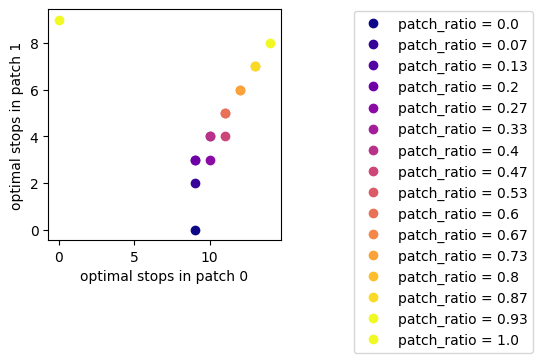

In [10]:
cmap = mpl.colormaps['plasma'].resampled(window_size_max)

fig = plt.figure(figsize=(3,3),tight_layout=True,facecolor='white')
ax = plt.subplot(111)
for patch_ratio in range(window_size_max+1):
    plt.plot(best_x_indices[patch_ratio],best_y_indices[patch_ratio],'o',c = cmap(patch_ratio/window_size_max), label = f'patch_ratio = {round(patch_ratio/window_size_max, 2)}')
    plt.xlabel('optimal stops in patch 0')
    plt.ylabel('optimal stops in patch 1')

# Create and configure the legend
ax.legend(loc='upper center', bbox_to_anchor=(1.7, 1.02),)

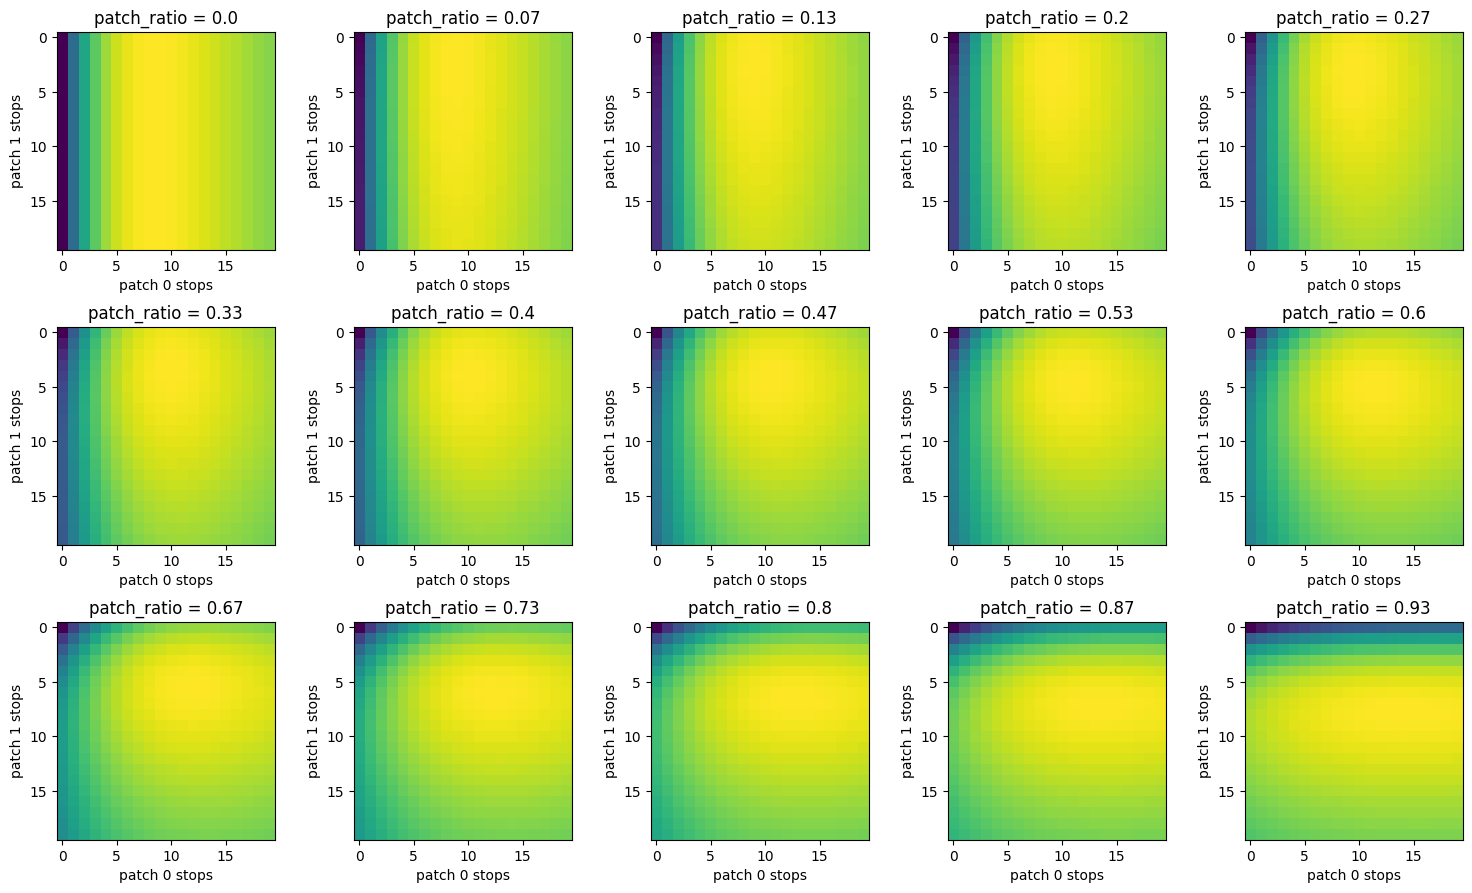

In [11]:
n_patch_ratios, n_x, n_y = grid.shape

fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(15, 9))
axs = axs.flatten()

for i, patch_ratio in enumerate(range(0, n_patch_ratios-1, n_patch_ratios//15)):
    ax = axs[i]
    ax.imshow(grid[patch_ratio].T, cmap='viridis')
    ax.set_title(f'patch_ratio = {round(patch_ratio/window_size_max, 2)}')
    ax.set_xlabel('patch 0 stops')
    ax.set_ylabel('patch 1 stops')

plt.tight_layout()
plt.show()